In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style("whitegrid")

Pharmacies = pd.read_csv(r"G:\Healthcare data\PHARMACIES\archive (5)\Pharmacies.csv", low_memory=False)

In [2]:
# SECTION 1: DATA OVERVIEW & INITIAL EXPLORATION

print("="*80)
print("PHARMACY DATA ANALYSIS")
print("="*80)

print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"Shape: {Pharmacies.shape}")
print(f"\nDataset Info:")
print(Pharmacies.info())

PHARMACY DATA ANALYSIS

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Shape: (62973, 51)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62973 entries, 0 to 62972
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID         62973 non-null  int64  
 1   ID          62973 non-null  int64  
 2   SECCLASS    62973 non-null  object 
 3   NAME        62973 non-null  object 
 4   TELEPHONE   62973 non-null  object 
 5   ADDRESS     62973 non-null  object 
 6   ADDRESS2    62973 non-null  object 
 7   CITY        62973 non-null  object 
 8   STATE       62973 non-null  object 
 9   ZIP         62973 non-null  int64  
 10  ZIPP4       62973 non-null  object 
 11  COUNTY      62973 non-null  object 
 12  FIPS        62973 non-null  int64  
 13  CONTDATE    61408 non-null  object 
 14  CONTHOW     62973 non-null  object 
 15  GEODATE     62973 non-null  ob

In [3]:
# Missing data analysis
print("\n2. DATA QUALITY ASSESSMENT")
print("-" * 80)
def missing_summary(df):
    missing = df.isnull().mean().mul(100).round(2)
    return missing[missing > 0].sort_values(ascending=False)

missing_data = missing_summary(Pharmacies)
if len(missing_data) > 0:
    print("Missing Data Summary (%):")
    print(missing_data)
    print(f"\n INSIGHT: {len(missing_data)} columns have missing values. Top missing: {missing_data.index[0]} ({missing_data.iloc[0]:.1f}%)")
else:
    print("No missing data detected")



2. DATA QUALITY ASSESSMENT
--------------------------------------------------------------------------------
Missing Data Summary (%):
CONTDATE    2.49
PROVID_11   0.05
PROVID_52   0.01
PROVID_56   0.01
dtype: float64

 INSIGHT: 4 columns have missing values. Top missing: CONTDATE (2.5%)


In [4]:
# SECTION 2: DATA CLEANING & FEATURE ENGINEERING

print("\n" + "="*80)
print("DATA CLEANING & FEATURE ENGINEERING")
print("="*80)

# Normalize text fields for consistent analysis
def normalize_text(col):
    return (col.astype(str).str.upper()
            .str.replace(r"[^\w\s]", "", regex=True)
            .str.replace(r"\s+", " ", regex=True)
            .str.strip())

Pharmacies["ADDRESS_NORM"] = normalize_text(Pharmacies["ADDRESS"].fillna(Pharmacies["PROVID_20"]))
Pharmacies["CITY_NORM"] = normalize_text(Pharmacies["CITY"].fillna(Pharmacies["PROVID_21"]))
Pharmacies["STATE_NORM"] = normalize_text(Pharmacies["STATE"].fillna(Pharmacies["PROVID_22"]))

# Parse contract dates
Pharmacies["CONTDATE"] = pd.to_datetime(Pharmacies["CONTDATE"], errors="coerce")
Pharmacies["YEAR"] = Pharmacies["CONTDATE"].dt.year

# Identify chain pharmacies
chain_keywords = ["CVS", "WALGREENS", "SAFEWAY", "COSTCO", "KAISER", "WALMART", "RITE AID"]
Pharmacies["CHAIN_FLAG"] = Pharmacies["NAME"].str.contains("|".join(chain_keywords), case=False, na=False)

# Identify duplicate locations
Pharmacies["DUPLICATE_LOCATION_FLAG"] = Pharmacies.duplicated(
    subset=["ADDRESS_NORM", "CITY_NORM", "STATE_NORM"], keep=False)

print("\n Data cleaning completed: normalized text, parsed dates, created quality flags")




DATA CLEANING & FEATURE ENGINEERING

 Data cleaning completed: normalized text, parsed dates, created quality flags



GEOGRAPHIC DISTRIBUTION ANALYSIS

Top 10 States by Pharmacy Count:
STATE_NORM
CA    5802
FL    4376
NY    4352
TX    4339
PA    2819
OH    2331
MI    2259
IL    2254
GA    2179
NC    1996
dtype: int64

 INSIGHT: CA leads with 5,802 pharmacies (9.2% of total)


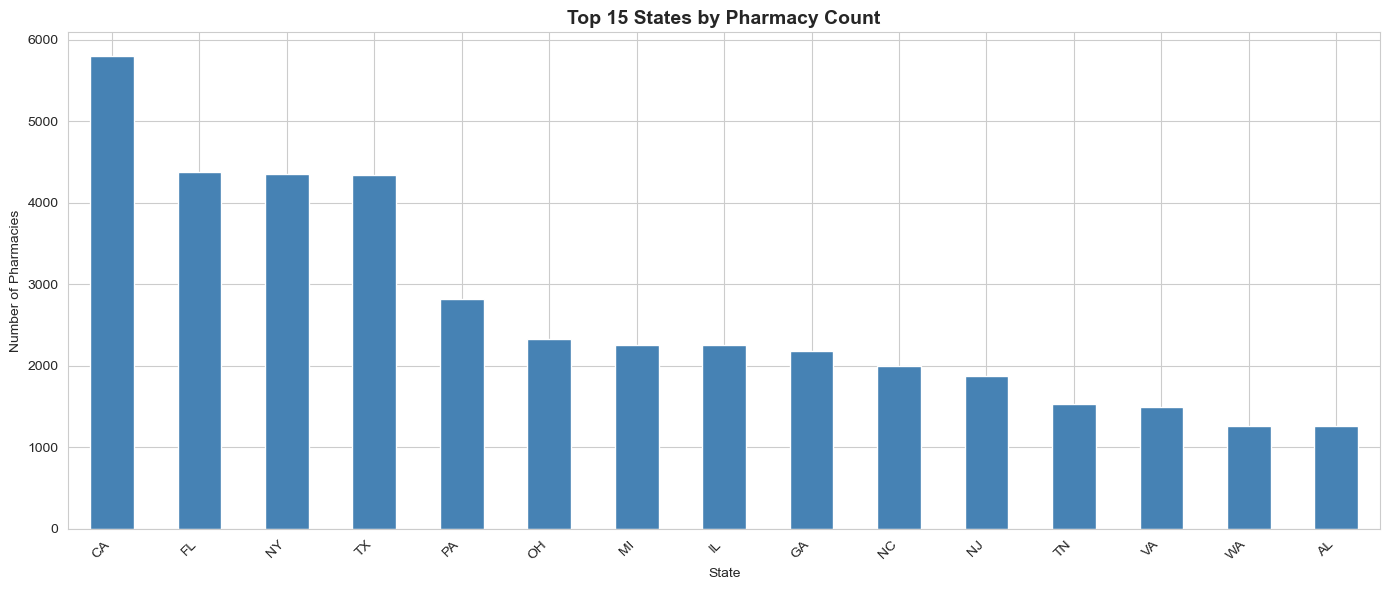

In [5]:
# SECTION 3: GEOGRAPHIC DISTRIBUTION ANALYSIS

print("\n" + "="*80)
print("GEOGRAPHIC DISTRIBUTION ANALYSIS")
print("="*80)

# State-level analysis
state_counts = Pharmacies.groupby("STATE_NORM").size().sort_values(ascending=False)
print("\nTop 10 States by Pharmacy Count:")
print(state_counts.head(10))

top_state = state_counts.index[0]
top_count = state_counts.iloc[0]
print(f"\n INSIGHT: {top_state} leads with {top_count:,} pharmacies ({100*top_count/len(Pharmacies):.1f}% of total)")

# Visualize state distribution
plt.figure(figsize=(14, 6))
state_counts.head(15).plot(kind="bar", color='steelblue')
plt.title("Top 15 States by Pharmacy Count", fontsize=14, fontweight='bold')
plt.ylabel("Number of Pharmacies")
plt.xlabel("State")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


County Coverage: 1826 unique counties

Top 10 Counties by Pharmacy Count:
COUNTY
LOS ANGELES    1653
ORANGE          899
COOK            887
HARRIS          817
JEFFERSON       809
MARICOPA        718
MONTGOMERY      707
KINGS           664
MIAMI-DADE      647
WAYNE           635
dtype: int64

 INSIGHT: 294 counties have ≤2 pharmacies (potential underserved areas)


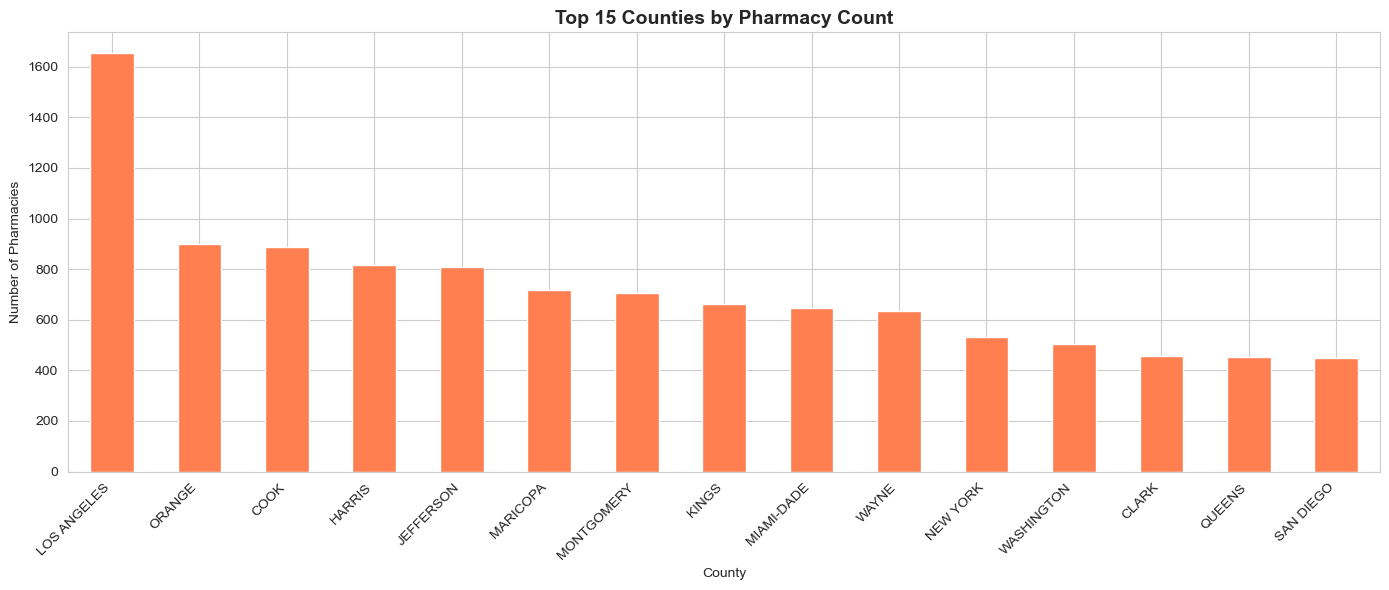

In [6]:
county_counts = Pharmacies.groupby("COUNTY").size().sort_values(ascending=False)
print(f"\nCounty Coverage: {county_counts.shape[0]} unique counties")
print("\nTop 10 Counties by Pharmacy Count:")
print(county_counts.head(10))

low_coverage_counties = county_counts[county_counts <= 2]
print(f"\n INSIGHT: {len(low_coverage_counties)} counties have ≤2 pharmacies (potential underserved areas)")

# Visualize county distribution
plt.figure(figsize=(14, 6))
county_counts.head(15).plot(kind="bar", color='coral')
plt.title("Top 15 Counties by Pharmacy Count", fontsize=14, fontweight='bold')
plt.ylabel("Number of Pharmacies")
plt.xlabel("County")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


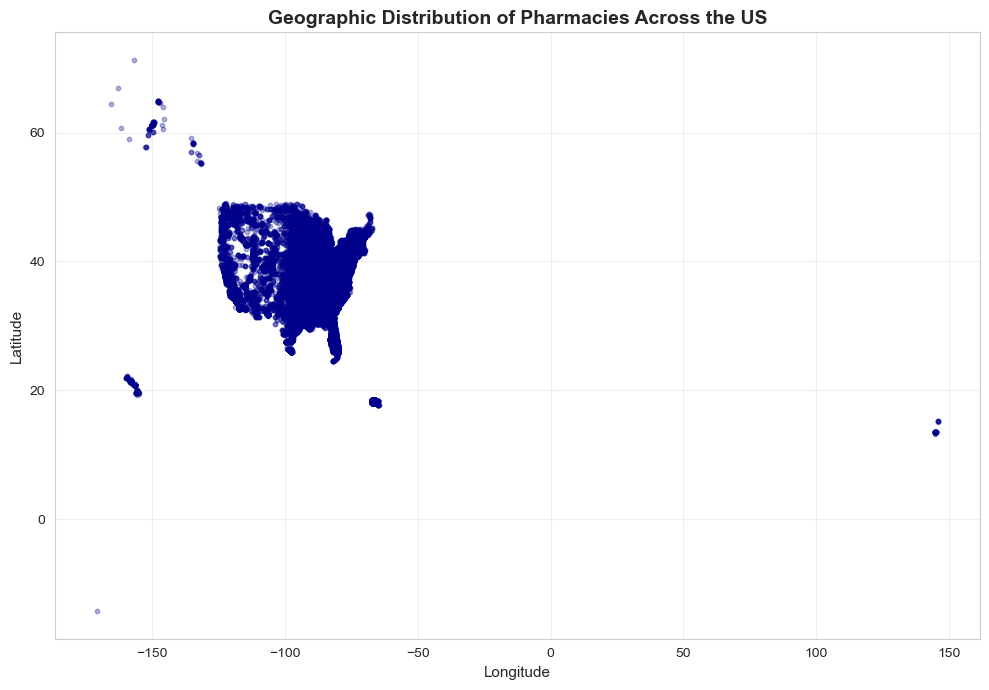

In [15]:
# Geographic scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(Pharmacies["X"], Pharmacies["Y"], alpha=0.3, s=10, c='darkblue')
plt.xlabel("Longitude", fontsize=11)
plt.ylabel("Latitude", fontsize=11)
plt.title("Geographic Distribution of Pharmacies Across the US", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# SECTION 4: BUSINESS TYPE & MARKET STRUCTURE

print("\n" + "="*80)
print("BUSINESS TYPE & MARKET STRUCTURE")
print("="*80)

# Chain vs Independent analysis
chain_distribution = Pharmacies["CHAIN_FLAG"].value_counts(normalize=True) * 100
print("\nChain vs Independent Pharmacies:")
print(f"Independent: {chain_distribution[False]:.1f}%")
print(f"Chain: {chain_distribution[True]:.1f}%")
print(f"\n INSIGHT: Chain pharmacies represent {chain_distribution[True]:.1f}% of the market")

# Entity type analysis
if "ENT_TYPE" in Pharmacies.columns:
    entity_distribution = Pharmacies["ENT_TYPE"].value_counts(normalize=True) * 100
    print("\nEntity Type Distribution:")
    print(entity_distribution)

# NAICS classification
naics_counts = Pharmacies["NAICSDESCR"].value_counts()
print(f"\nNAICS Classifications: {len(naics_counts)} unique categories")
print("\nTop 5 NAICS Descriptions:")
print(naics_counts.head())



BUSINESS TYPE & MARKET STRUCTURE

Chain vs Independent Pharmacies:
Independent: 67.5%
Chain: 32.5%

 INSIGHT: Chain pharmacies represent 32.5% of the market

Entity Type Distribution:
ENT_TYPE
2   100.00
      0.00
Name: proportion, dtype: float64

NAICS Classifications: 1 unique categories

Top 5 NAICS Descriptions:
NAICSDESCR
PHARMACIES    62973
Name: count, dtype: int64


In [31]:
# SECTION 5: TEMPORAL ANALYSIS

print("\n" + "="*80)
print("TEMPORAL ANALYSIS - PHARMACY GROWTH TRENDS")
print("="*80)

yearly_counts = Pharmacies.groupby("YEAR").size().sort_index()
print("\nPharmacies by Contract Year:")
print(yearly_counts)

if len(yearly_counts) > 1:
    growth_rate = ((yearly_counts.iloc[-1] - yearly_counts.iloc[0]) / yearly_counts.iloc[0] * 100)
    print(f"\n INSIGHT: Growth from {yearly_counts.index[0]} to {yearly_counts.index[-1]}: {growth_rate:+.1f}%")
    
    # Visualize temporal trends
    plt.figure(figsize=(12, 5))
    yearly_counts.plot(kind='line', marker='o', linewidth=2, markersize=8, color='darkgreen')
    plt.title("Pharmacy Contract Registration Trends Over Time", fontsize=14, fontweight='bold')
    plt.ylabel("Number of Pharmacies")
    plt.xlabel("Year")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



TEMPORAL ANALYSIS - PHARMACY GROWTH TRENDS

Pharmacies by Contract Year:
YEAR
2010.00    61408
dtype: int64


In [8]:
# SECTION 6: DATA QUALITY METRICS

print("\n" + "="*80)
print("DATA QUALITY METRICS")
print("="*80)

duplicate_rate = Pharmacies["DUPLICATE_LOCATION_FLAG"].mean() * 100

print(f"Duplicate Location Rate: {duplicate_rate:.2f}%")

if duplicate_rate > 10:
    print(f"  WARNING: Significant duplicate locations detected ({duplicate_rate:.1f}%)")



DATA QUALITY METRICS
Duplicate Location Rate: 1.35%


In [33]:
# SECTION 7: EXECUTIVE SUMMARY - KEY PERFORMANCE INDICATORS

print("\n" + "="*80)
print("EXECUTIVE SUMMARY - KEY PERFORMANCE INDICATORS")
print("="*80)

healthcare_kpis = {
    "Total Records": len(Pharmacies),
    "Unique Physical Locations": Pharmacies[["ADDRESS_NORM", "CITY_NORM", "STATE_NORM"]].drop_duplicates().shape[0],
    "States Covered": Pharmacies["STATE_NORM"].nunique(),
    "Counties Covered": Pharmacies["COUNTY"].nunique(),
    "Chain Pharmacy %": chain_distribution[True],
    "Independent Pharmacy %": chain_distribution[False],
    "Duplicate Location Rate %": duplicate_rate,
}

kpi_summary = pd.Series(healthcare_kpis)
print("\n" + kpi_summary.to_string())

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print(f"1. Geographic Coverage: {healthcare_kpis['States Covered']} states, {healthcare_kpis['Counties Covered']} counties")
print(f"2. Market Structure: {chain_distribution[True]:.1f}% chain pharmacies dominate the market")
print(f"3. Data Quality: {duplicate_rate:.1f}% duplicate locations")
print(f"4. Top State: {top_state} with {top_count:,} pharmacies")
print(f"5. Underserved Areas: {len(low_coverage_counties)} counties with minimal pharmacy access")
print("="*80)


EXECUTIVE SUMMARY - KEY PERFORMANCE INDICATORS

Total Records               62973.00
Unique Physical Locations   62509.00
States Covered                 56.00
Counties Covered             1826.00
Chain Pharmacy %               32.50
Independent Pharmacy %         67.50
Duplicate Location Rate %       1.35
Invalid NPI Rate %            100.00

KEY FINDINGS:
1. Geographic Coverage: 56 states, 1826 counties
2. Market Structure: 32.5% chain pharmacies dominate the market
3. Data Quality: 0.0% valid NPIs, 1.4% duplicate locations
4. Top State: CA with 5,802 pharmacies
5. Underserved Areas: 294 counties with minimal pharmacy access
